<a href="https://colab.research.google.com/github/AleksandraBelousova/Diabetes-Prediction-Model/blob/main/Comparative_Analysis_of_Predictive_Models_for_Diabetes_Diagnosis_using_Clinical_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.7 MB/s eta 0:00:00


In [2]:
import kagglehub
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def download_and_prepare_data(dataset_name):
    try:
        path = kagglehub.dataset_download(dataset_name)
        data_path = f"{path}/diabetes.csv"
        df = pd.read_csv(data_path)
        return preprocess_data(df)
    except Exception as e:
        raise SystemExit(f"Failed to download dataset: {e}")

def preprocess_data(dataframe):
    """Impute missing values and scale numerical features."""
    imputer = IterativeImputer(random_state=42)
    scaler = StandardScaler()
    num_features_impute = ['Glucose', 'BMI', 'BloodPressure', 'SkinThickness', 'Insulin']
    num_features = num_features_impute + ['Pregnancies', 'DiabetesPedigreeFunction', 'Age']

    dataframe[num_features_impute] = imputer.fit_transform(dataframe[num_features_impute])
    dataframe[num_features] = scaler.fit_transform(dataframe[num_features])
    return dataframe

def evaluate_model(model, features, target, cv=5):
    """Evaluate model with cross-validation."""
    scoring = ['accuracy', 'roc_auc', 'average_precision', 'f1']
    return cross_validate(model, features, target, cv=cv, scoring=scoring, return_train_score=True)

def plot_roc_curve(y_true, y_pred_prob):
    """Plot ROC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    auc_score = roc_auc_score(y_true, y_pred_prob)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})', color='darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy', label='Chance')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

df = pd.read_csv('diabetes.csv')
features = df.drop('Outcome', axis=1)
target = df['Outcome']

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

parameter_grid = {
    'classifier__C': np.logspace(-4, 2, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

scoring = {
    'ROC_AUC': make_scorer(roc_auc_score),
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1': make_scorer(f1_score)
}
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    pipeline,
    parameter_grid,
    scoring=scoring,
    cv=stratified_k_fold,
    refit='ROC_AUC',
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(features, target)

print(grid_search.best_params_)
print(grid_search.best_score_)

results = pd.DataFrame(grid_search.cv_results_)
print(results[['params', 'mean_train_ROC_AUC', 'mean_test_ROC_AUC', 'mean_train_Accuracy', 'mean_test_Accuracy', 'mean_train_F1', 'mean_test_F1']])

{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
0.7515835080363382
                                               params  mean_train_ROC_AUC  \
0   {'classifier__C': 0.0001, 'classifier__penalty...            0.500000   
1   {'classifier__C': 0.0001, 'classifier__penalty...            0.500000   
2   {'classifier__C': 0.0001, 'classifier__penalty...            0.731749   
3   {'classifier__C': 0.0001, 'classifier__penalty...            0.731749   
4   {'classifier__C': 0.001, 'classifier__penalty'...            0.500000   
5   {'classifier__C': 0.001, 'classifier__penalty'...            0.500000   
6   {'classifier__C': 0.001, 'classifier__penalty'...            0.736360   
7   {'classifier__C': 0.001, 'classifier__penalty'...            0.736825   
8   {'classifier__C': 0.01, 'classifier__penalty':...            0.712002   
9   {'classifier__C': 0.01, 'classifier__penalty':...            0.712467   
10  {'classifier__C': 0.01, 'classifier__penalt

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
import warnings

warnings.filterwarnings("ignore")

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, stratify=target, random_state=42)

def create_pipeline(oversampler=None):
    """Create a machine learning pipeline with optional oversampling."""
    steps = [('scaler', StandardScaler())]
    if oversampler:
        steps.insert(0, ('oversampler', oversampler))
    steps.append(('classifier', LogisticRegression(random_state=42, solver='liblinear')))
    return ImbalancedPipeline(steps)

parameter_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

scoring = {
    'ROC_AUC': make_scorer(roc_auc_score),
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1': make_scorer(f1_score),
    'Balanced_Accuracy': make_scorer(balanced_accuracy_score)
}
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oversamplers = [None, SMOTE(random_state=42), ADASYN(random_state=42), SMOTETomek(random_state=42)]
best_model = None
best_score = 0

for oversampler in oversamplers:
    pipeline = create_pipeline(oversampler)
    grid_search = GridSearchCV(
        pipeline,
        parameter_grid,
        scoring=scoring,
        cv=stratified_k_fold,
        refit='ROC_AUC',
        n_jobs=-1,
        return_train_score=True,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    oversampler_name = type(oversampler).__name__ if oversampler else 'None'
    print(f"Oversampler: {oversampler_name}")
    print("Best parameters:", grid_search.best_params_)
    print("Best ROC_AUC:", grid_search.best_score_)

    results = pd.DataFrame(grid_search.cv_results_)
    print(results[['params', 'mean_train_ROC_AUC', 'mean_test_ROC_AUC', 'mean_train_Accuracy', 'mean_test_Accuracy', 'mean_train_F1', 'mean_test_F1', 'mean_test_Balanced_Accuracy']])
    print("-" * 50)

    y_pred = grid_search.predict(X_test)
    test_roc_auc = roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1])
    test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    print(f"Test ROC_AUC: {test_roc_auc}")
    print(f"Test Balanced Accuracy: {test_balanced_accuracy}")
    print(f"Test F1: {test_f1}")
    print("=" * 50)

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model = grid_search

best_oversampler_name = type(best_model.best_estimator_.named_steps['oversampler']).__name__ if 'oversampler' in best_model.best_estimator_.named_steps else 'None'
print(f"Best Model Oversampler: {best_oversampler_name}")
print("Best Model parameters:", best_model.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Oversampler: None
Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l2'}
Best ROC_AUC: 0.7351138211382114
                                              params  mean_train_ROC_AUC  \
0  {'classifier__C': 0.1, 'classifier__penalty': ...            0.738893   
1  {'classifier__C': 0.1, 'classifier__penalty': ...            0.744843   
2  {'classifier__C': 1, 'classifier__penalty': 'l1'}            0.746134   
3  {'classifier__C': 1, 'classifier__penalty': 'l2'}            0.748047   
4  {'classifier__C': 10, 'classifier__penalty': '...            0.748043   
5  {'classifier__C': 10, 'classifier__penalty': '...            0.748043   

   mean_test_ROC_AUC  mean_train_Accuracy  mean_test_Accuracy  mean_train_F1  \
0           0.727553             0.787761            0.774333       0.654876   
1           0.732553             0.789497            0.777811       0.664361   
2           0.731280             0.790800       

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier

diabetes_data = pd.read_csv('diabetes.csv')
columns_to_replace_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
diabetes_data[columns_to_replace_zeros] = diabetes_data[columns_to_replace_zeros].replace(0, np.nan)

features = diabetes_data.drop('Outcome', axis=1)
target = diabetes_data['Outcome']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)
catboost_model = CatBoostClassifier(random_state=42, verbose=0, early_stopping_rounds=50)

parameter_distributions = {
    'iterations': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.03, 0.1, 0.3],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 10],
    'border_count': [32, 64, 128, 256]
}
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring_metrics = {
    'ROC_AUC': make_scorer(roc_auc_score),
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1': make_scorer(f1_score)
}
randomized_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=parameter_distributions,
    n_iter=60,
    scoring=scoring_metrics,
    cv=stratified_k_fold,
    n_jobs=-1,
    random_state=42,
    refit="ROC_AUC",
    return_train_score=True
)
randomized_search.fit(features_train, target_train)

print("Best hyperparameters:", randomized_search.best_params_)
print("Best ROC-AUC score:", randomized_search.best_score_)

randomized_search_results = pd.DataFrame(randomized_search.cv_results_)
print(randomized_search_results[['params', 'mean_train_ROC_AUC', 'mean_test_ROC_AUC', 'mean_train_Accuracy', 'mean_test_Accuracy', 'mean_train_F1', 'mean_test_F1']])

best_catboost_model = randomized_search.best_estimator_
predicted_probabilities = best_catboost_model.predict_proba(features_test)[:, 1]
roc_auc_score_on_test_set = roc_auc_score(target_test, predicted_probabilities)
print("ROC-AUC on the test set:", roc_auc_score_on_test_set)

Best hyperparameters: {'learning_rate': 0.03, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 6, 'border_count': 64}
Best ROC-AUC score: 0.7416431339977851
                                               params  mean_train_ROC_AUC  \
0   {'learning_rate': 0.03, 'l2_leaf_reg': 10, 'it...            0.729250   
1   {'learning_rate': 0.03, 'l2_leaf_reg': 3, 'ite...            0.998834   
2   {'learning_rate': 0.01, 'l2_leaf_reg': 10, 'it...            0.978343   
3   {'learning_rate': 0.3, 'l2_leaf_reg': 10, 'ite...            1.000000   
4   {'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iter...            1.000000   
5   {'learning_rate': 0.3, 'l2_leaf_reg': 5, 'iter...            0.929118   
6   {'learning_rate': 0.3, 'l2_leaf_reg': 10, 'ite...            1.000000   
7   {'learning_rate': 0.1, 'l2_leaf_reg': 10, 'ite...            1.000000   
8   {'learning_rate': 0.01, 'l2_leaf_reg': 10, 'it...            0.732538   
9   {'learning_rate': 0.3, 'l2_leaf_reg': 5, 'iter...            0.990344   

Best Hyperparameters: {'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 200, 'depth': 4, 'border_count': 256}
Best ROC-AUC Score: 0.8424501661129569


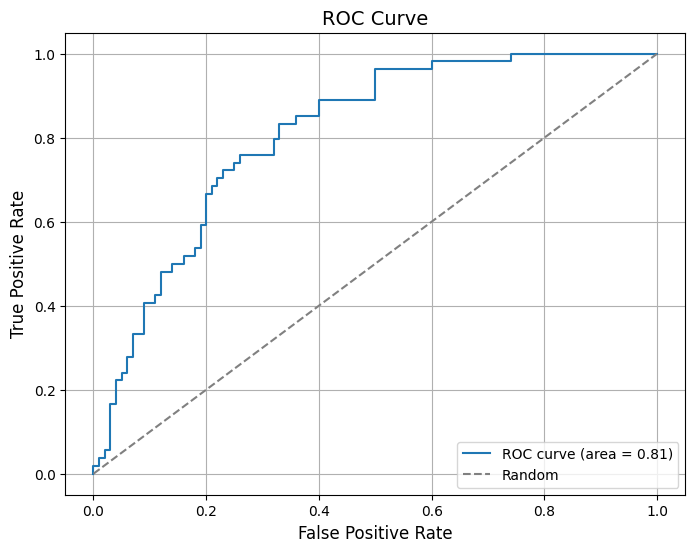

Feature Importances:
                  Feature Id  Importances
0               Pregnancies     5.364215
1                   Glucose    43.194841
2             BloodPressure     2.691035
3             SkinThickness     2.175693
4                   Insulin     4.857986
5                       BMI    23.099968
6  DiabetesPedigreeFunction     7.066878
7                       Age    11.549386


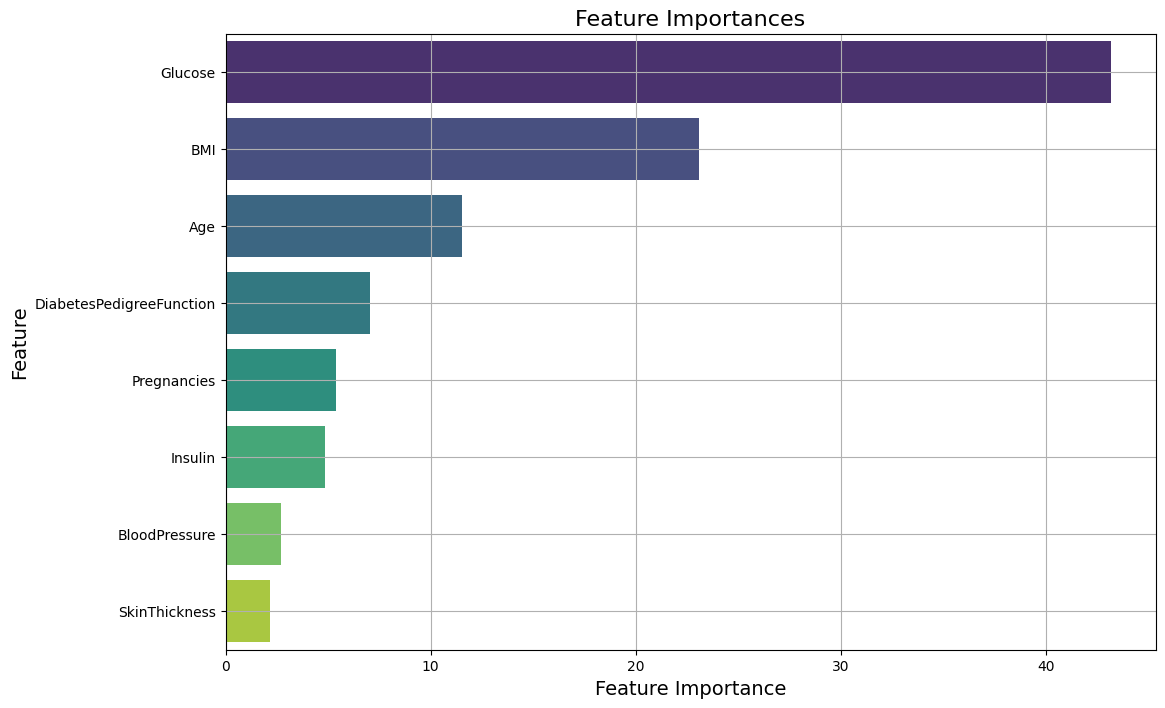

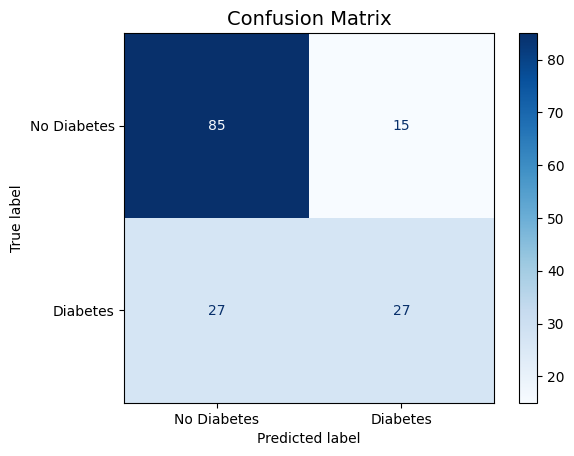

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
import pandas as pd

diabetes_data = pd.read_csv('/content/diabetes.csv')

numeric_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
for feature in numeric_features:
    diabetes_data[feature] = diabetes_data[feature].replace(0, diabetes_data[feature].mean())
features = diabetes_data.drop('Outcome', axis=1)
target = diabetes_data['Outcome']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)
catboost_model = CatBoostClassifier(random_state=42, verbose=0)
param_distributions = {
    'iterations': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.03, 0.1, 0.3],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 10],
    'border_count': [32, 64, 128, 256]
}
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
randomized_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='roc_auc',
    cv=stratified_kfold,
    n_jobs=-1,
    random_state=42,
    verbose=0
)
randomized_search.fit(features_train, target_train)

best_params = randomized_search.best_params_
best_model = CatBoostClassifier(iterations=best_params['iterations'],
                                learning_rate=best_params['learning_rate'],
                                depth=best_params['depth'],
                                l2_leaf_reg=best_params['l2_leaf_reg'],
                                border_count=best_params['border_count'],
                                random_state=42,
                                verbose=0,
                                early_stopping_rounds=50)

best_model.fit(features_train, target_train, eval_set=(features_test, target_test))
print(f"Best Hyperparameters: {randomized_search.best_params_}")
print(f"Best ROC-AUC Score: {randomized_search.best_score_}")

probabilities = best_model.predict_proba(features_test)[:, 1]
roc_auc = roc_auc_score(target_test, probabilities)
fpr, tpr, _ = roc_curve(target_test, probabilities)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
feature_importances = pd.DataFrame({
    'Feature Id': features.columns,
    'Importances': best_model.get_feature_importance()
})
print("Feature Importances:\n", feature_importances)

plt.figure(figsize=(12, 8))
sns.barplot(x="Importances", y="Feature Id", data=feature_importances.sort_values(by="Importances", ascending=False), palette='viridis')
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importances', fontsize=16)
plt.grid(True)
plt.show()

predictions = best_model.predict(features_test)
cm = confusion_matrix(target_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=14)
plt.grid(False)
plt.show()

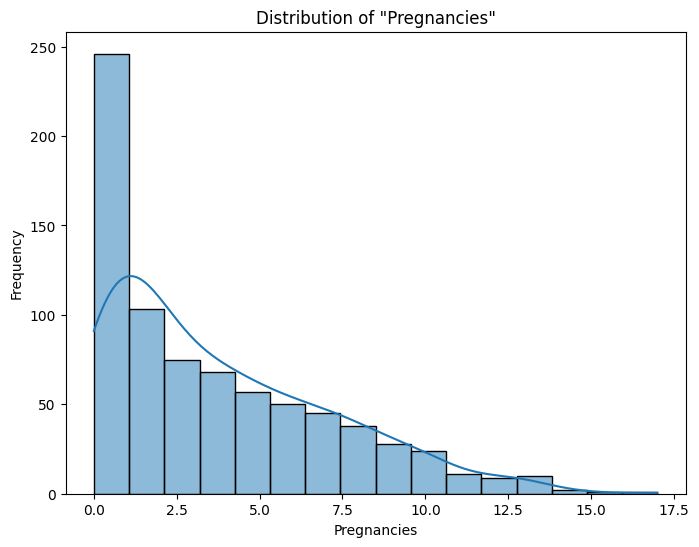

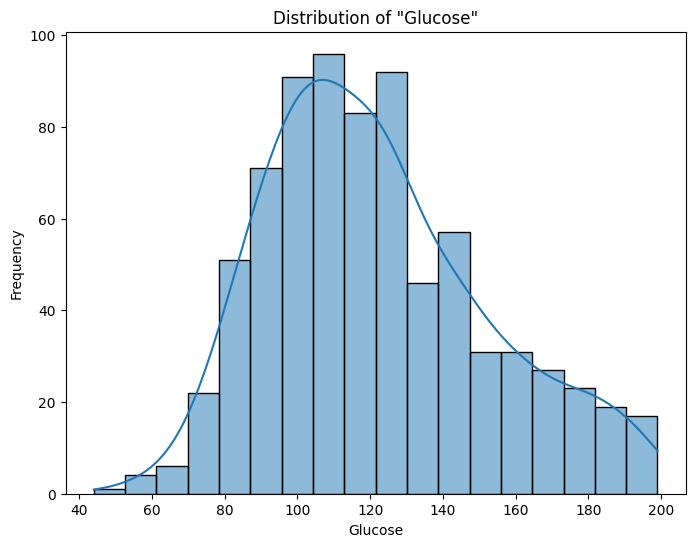

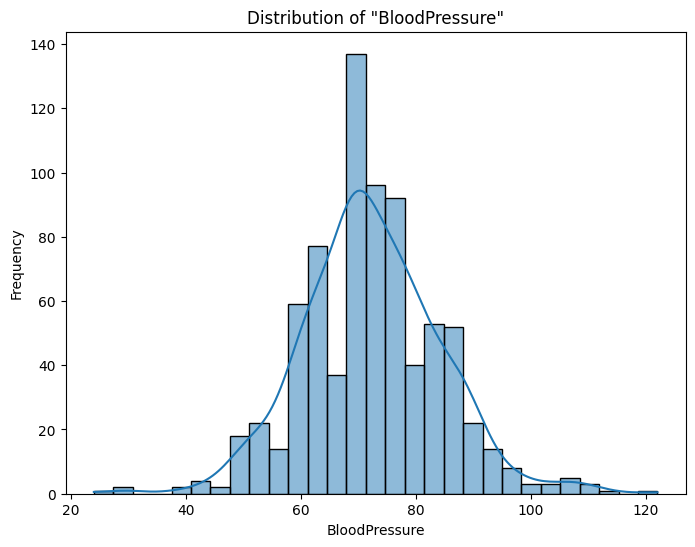

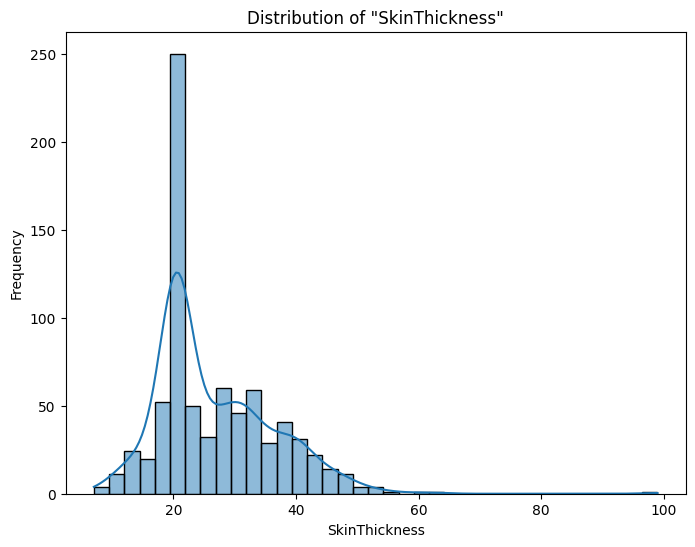

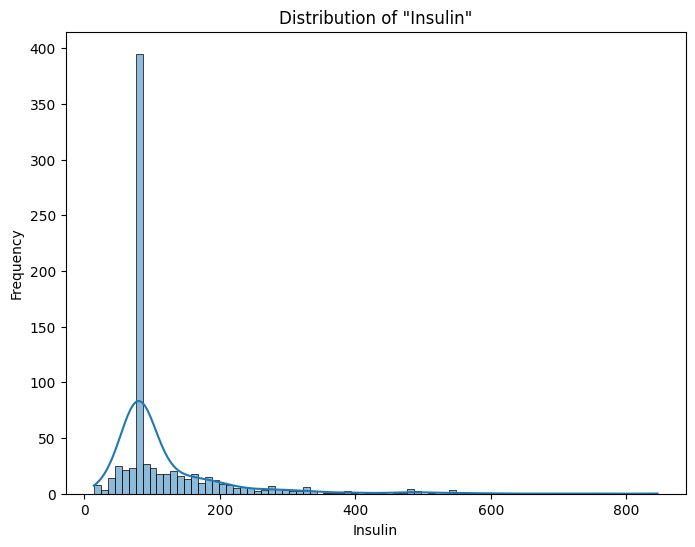

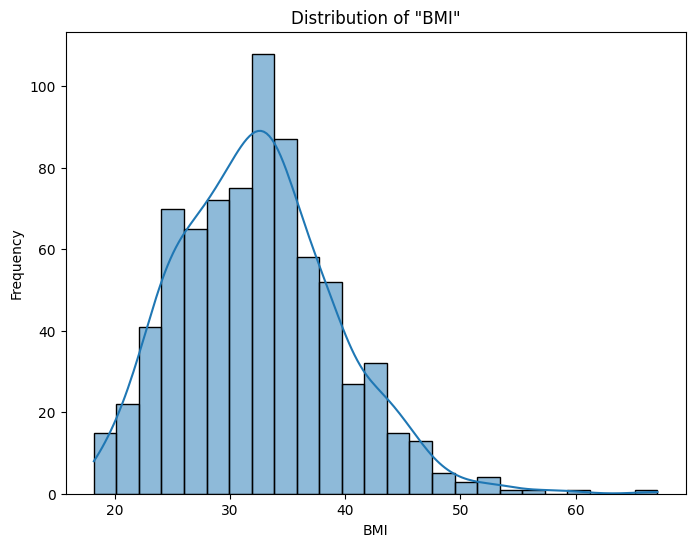

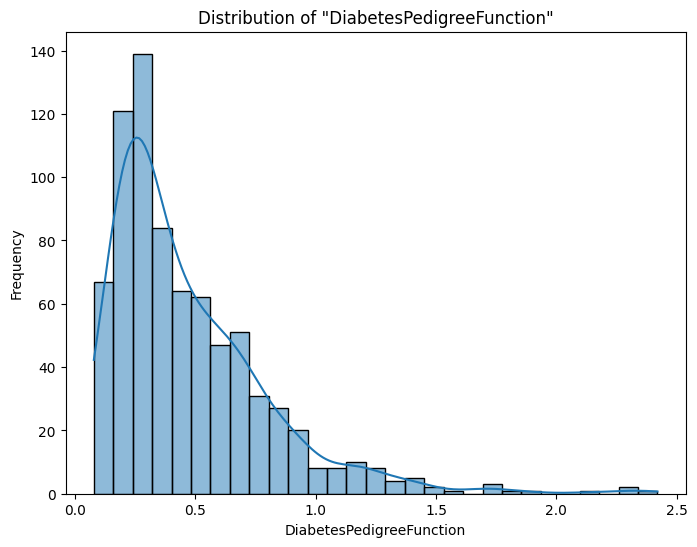

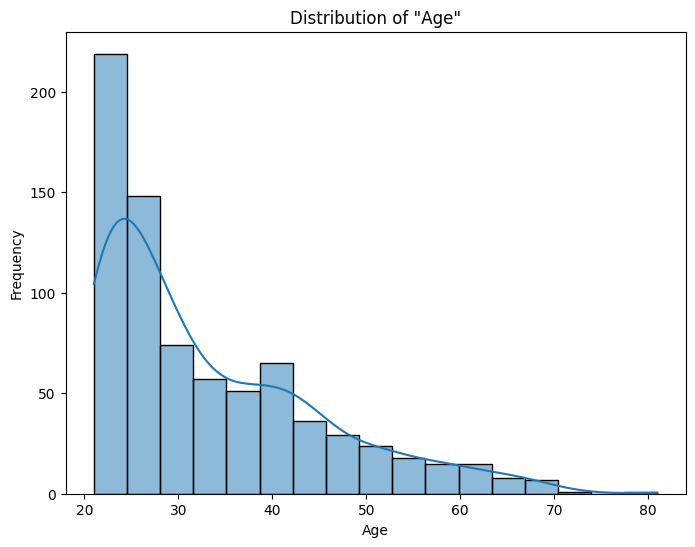

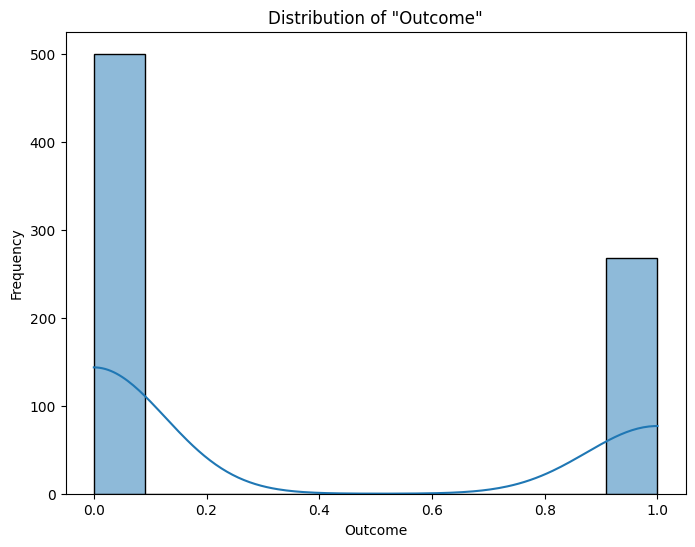

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

for column in diabetes_data.columns:
  plt.figure(figsize=(8, 6))
  sns.histplot(diabetes_data[column], kde=True)
  plt.title(f'Distribution of "{column}"')
  plt.xlabel(column)
  plt.ylabel('Frequency')
  plt.show()

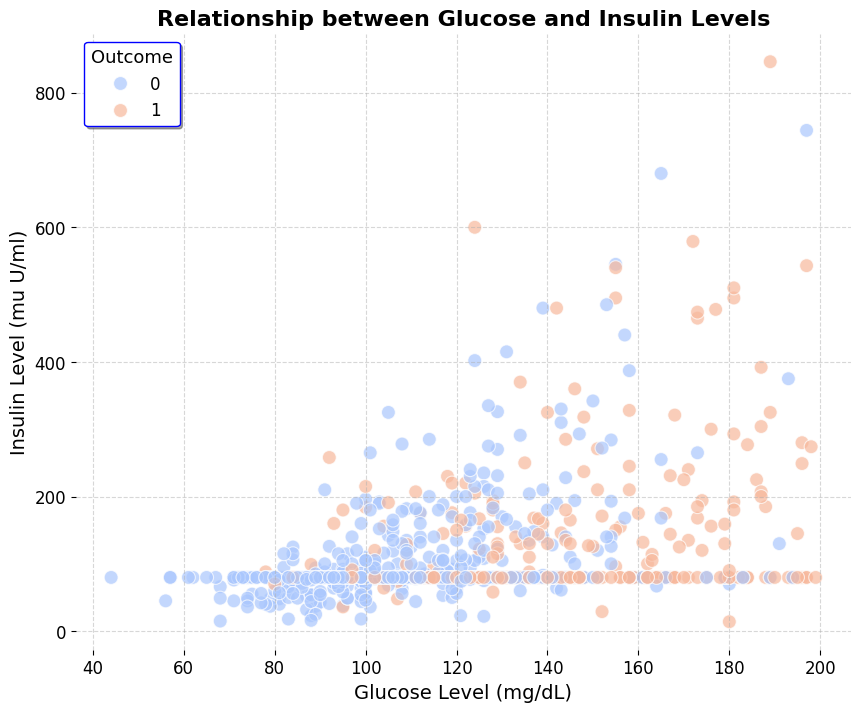

In [11]:
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    x='Glucose',
    y='Insulin',
    data=diabetes_data,
    hue='Outcome',
    alpha=0.7,
    s=100,
    palette='coolwarm',
    edgecolor='w',
    linewidth=0.8
)
plt.title('Relationship between Glucose and Insulin Levels', fontsize=16, fontweight='bold')
plt.xlabel('Glucose Level (mg/dL)', fontsize=14)
plt.ylabel('Insulin Level (mu U/ml)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Outcome', title_fontsize='13', fontsize='12', loc='upper left', frameon=True, shadow=True, edgecolor='b')
sns.despine(left=True, bottom=True)
plt.show()